## **GNN AND LSTM PROJECT USING TENSORFLOW AND KERAS**

- This traffic speed prediction project uses data on distances between nodes (monitoring points) and historical traffic speed data.
- The data is normalised and then fed into a combined GNN and LSTM model.
- GNNs allow the model to consider the spatial structure of the road network, while LSTMs capture temporal dependencies in traffic speeds, allowing for more accurate predictions of future speeds on the traffic network.

In [49]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops

### CREATE THE DATASEET BY GENERATING SYNTHETIC DATA

- **Distance Array (route_distances)**: An array of size 100×100 representing the distances between 100 monitoring points.

- **Speeds array (speeds_array)**: An array of size 200×100 representing the speeds recorded at 100 monitoring points over 200 time steps.

In [50]:
N = 10 # Number of nodes (control points)
T = 150 # Number of time steps

# Generating a random symmetric distance matrix
route_distances = np.random.rand(N, N) * 10000
route_distances = (route_distances + route_distances.T) / 2
np.fill_diagonal(route_distances, 0)

# Generate random speeds in the range [20, 80] km/h
speeds_matrix = np.random.uniform(20, 80, size=(T, N))

In [51]:
route_distances

array([[   0.        , 4875.61099045, 6125.20484458, 6325.02607882,
        7021.33973213, 3510.59413792, 4298.82167512, 7404.81953612,
        5598.83185438, 8630.37533346],
       [4875.61099045,    0.        , 4703.36229843, 5982.37685587,
        4782.2967349 , 7455.16617166, 5808.4916287 , 3659.96888665,
        2436.1967893 , 7029.60199224],
       [6125.20484458, 4703.36229843,    0.        , 3041.67499173,
        7962.89439668, 3972.66030261, 7011.81247862, 4728.23549102,
        2602.29892312, 4389.67936785],
       [6325.02607882, 5982.37685587, 3041.67499173,    0.        ,
        2933.22256119, 2290.54111289, 7581.11065519, 5416.744177  ,
        2541.23852471, 4853.02733904],
       [7021.33973213, 4782.2967349 , 7962.89439668, 2933.22256119,
           0.        , 2557.54732713, 7285.47546703, 5976.41675315,
        5184.07536817, 4625.82240911],
       [3510.59413792, 7455.16617166, 3972.66030261, 2290.54111289,
        2557.54732713,    0.        , 4192.05353387, 5245

In [52]:
speeds_matrix

array([[53.89113068, 52.10928569, 33.79370393, ..., 31.9967276 ,
        61.35909208, 49.14985333],
       [38.51264762, 78.23269657, 29.61204463, ..., 58.3344341 ,
        57.84234546, 24.58666197],
       [59.80926493, 79.31065627, 31.26152133, ..., 62.60864337,
        50.04247184, 20.02084535],
       ...,
       [46.25229013, 74.68236486, 44.49130625, ..., 74.42184939,
        65.43894607, 73.7206895 ],
       [23.00684372, 34.61052194, 69.50737494, ..., 32.38087113,
        36.22299376, 62.35085449],
       [79.95908265, 56.336387  , 43.86554894, ..., 21.11870085,
        65.92444872, 75.72650846]])

In [53]:
print("Route Distances", route_distances.shape)
print("Speed Matrix", speeds_matrix.shape)

Route Distances (10, 10)
Speed Matrix (150, 10)


### DATA NORMALISATION

In [54]:
from sklearn.preprocessing import StandardScaler

# Route_distances
route_distances_n = route_distances / np.max(route_distances)

# Speeds_array
scaler = StandardScaler()
speeds_matrix_n = scaler.fit_transform(speeds_matrix.reshape(-1, N)).reshape(T, N, 1)

### CONSTRUCTION OF THE MODEL

In [55]:
from sklearn.model_selection import train_test_split

# Split data into training and test
X = speeds_matrix_n[:-1]
y = speeds_matrix_n[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expands the adjacency matrix to match the number of samples in X_train and X_test
route_distances_expanded_train = np.expand_dims(route_distances_n, axis=0)
route_distances_expanded_train = np.repeat(route_distances_expanded_train, X_train.shape[0], axis=0)

route_distances_expanded_test = np.expand_dims(route_distances_n, axis=0)
route_distances_expanded_test = np.repeat(route_distances_expanded_test, X_test.shape[0], axis=0)

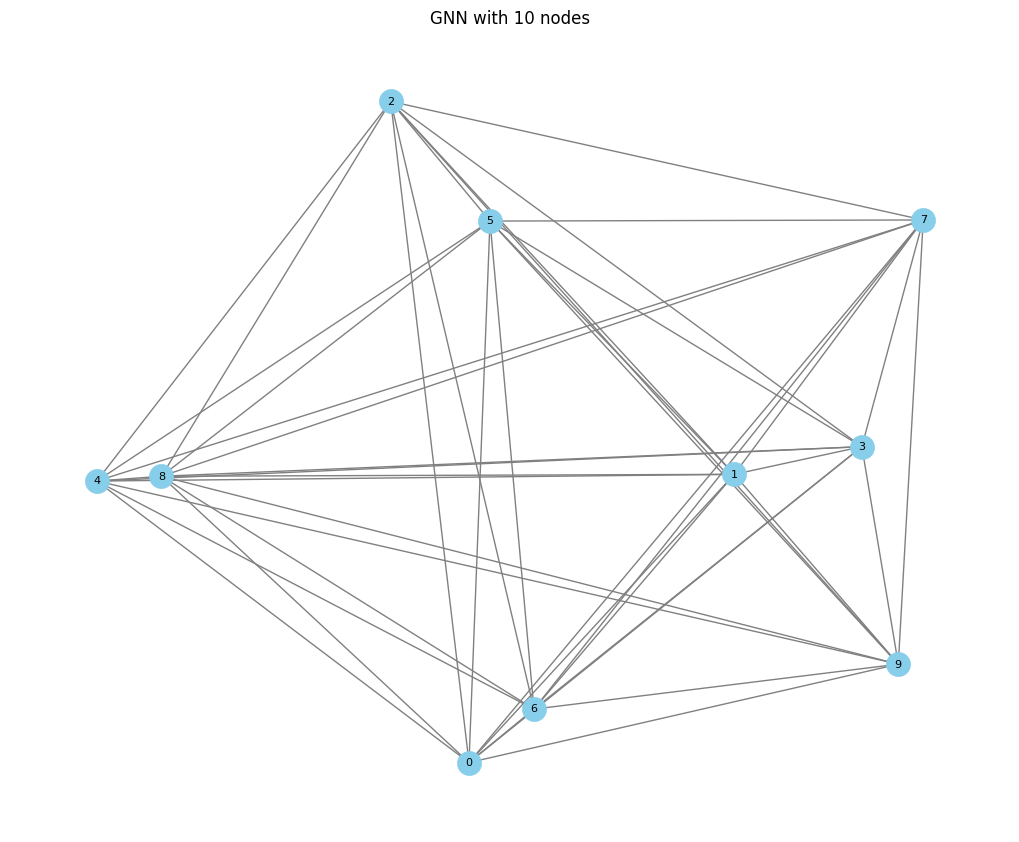

In [63]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_numpy_array(route_distances)

plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=300, node_color='skyblue', font_size=8, edge_color='gray', linewidths=0.5)
plt.title('GNN with 10 nodes')
plt.show()

In [56]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import layers, models, callbacks
import tensorflow.keras.backend as K

class GNNLayer(layers.Layer):
    def __init__(self, units, name=None):
        super(GNNLayer, self).__init__(name=name)
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)

    def call(self, inputs, adjacency_matrix):
        x = tf.matmul(inputs, self.kernel)
        x = tf.matmul(adjacency_matrix, x)
        return tf.nn.relu(x + self.bias)

def build_model(num_nodes, num_features):
    node_features_input = tf.keras.Input(shape=(num_nodes, num_features), name='Node_Features')
    adj_matrix_input = tf.keras.Input(shape=(num_nodes, num_nodes), name='Adjacency_Matrix')

    x = GNNLayer(64, name='GNN_Layer_1')(node_features_input, adj_matrix_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = GNNLayer(128, name='GNN_Layer_2')(x, adj_matrix_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten(name='Flatten')(x)
    x = layers.RepeatVector(T-1, name='RepeatVector')(x)  # I use T-1 timesteps to predict the next

    x = layers.LSTM(256, return_sequences=True, name='LSTM_1')(x)
    x = layers.LSTM(128, return_sequences=False, name='LSTM_2')(x)

    output = layers.Dense(num_nodes, name='Output', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = tf.keras.Model(inputs=[node_features_input, adj_matrix_input], outputs=output, name='GNN_LSTM_Model')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    return model

# Create the model
num_nodes = route_distances_n.shape[0]
num_features = speeds_matrix_n.shape[2]
model = build_model(num_nodes, num_features)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.summary()

Model: "GNN_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Node_Features       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Adjacency_Matrix    │ (None, 10, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GNN_Layer_1         │ (None, 10, 64)    │        128 │ Node_Features[0]… │
│ (GNNLayer)          │                   │            │ Adjacency_Matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 64)    │        256 │ GNN_Layer_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 10, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GNN_Layer_2         │ (None, 10, 128)   │      8,320 │ dropout_8[0][0],  │
│ (GNNLayer)          │                   │            │ Adjacency_Matrix… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ GNN_Layer_2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 10, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten (Flatten)   │ (None, 1280)      │          0 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RepeatVector        │ (None, 149, 1280) │          0 │ Flatten[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 149, 256)  │  1,573,888 │ RepeatVector[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_2 (LSTM)       │ (None, 128)       │    197,120 │ LSTM_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 10)        │      1,290 │ LSTM_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,781,514 (6.80 MB)

 Trainable params: 1,781,130 (6.79 MB)

 Non-trainable params: 384 (1.50 KB)

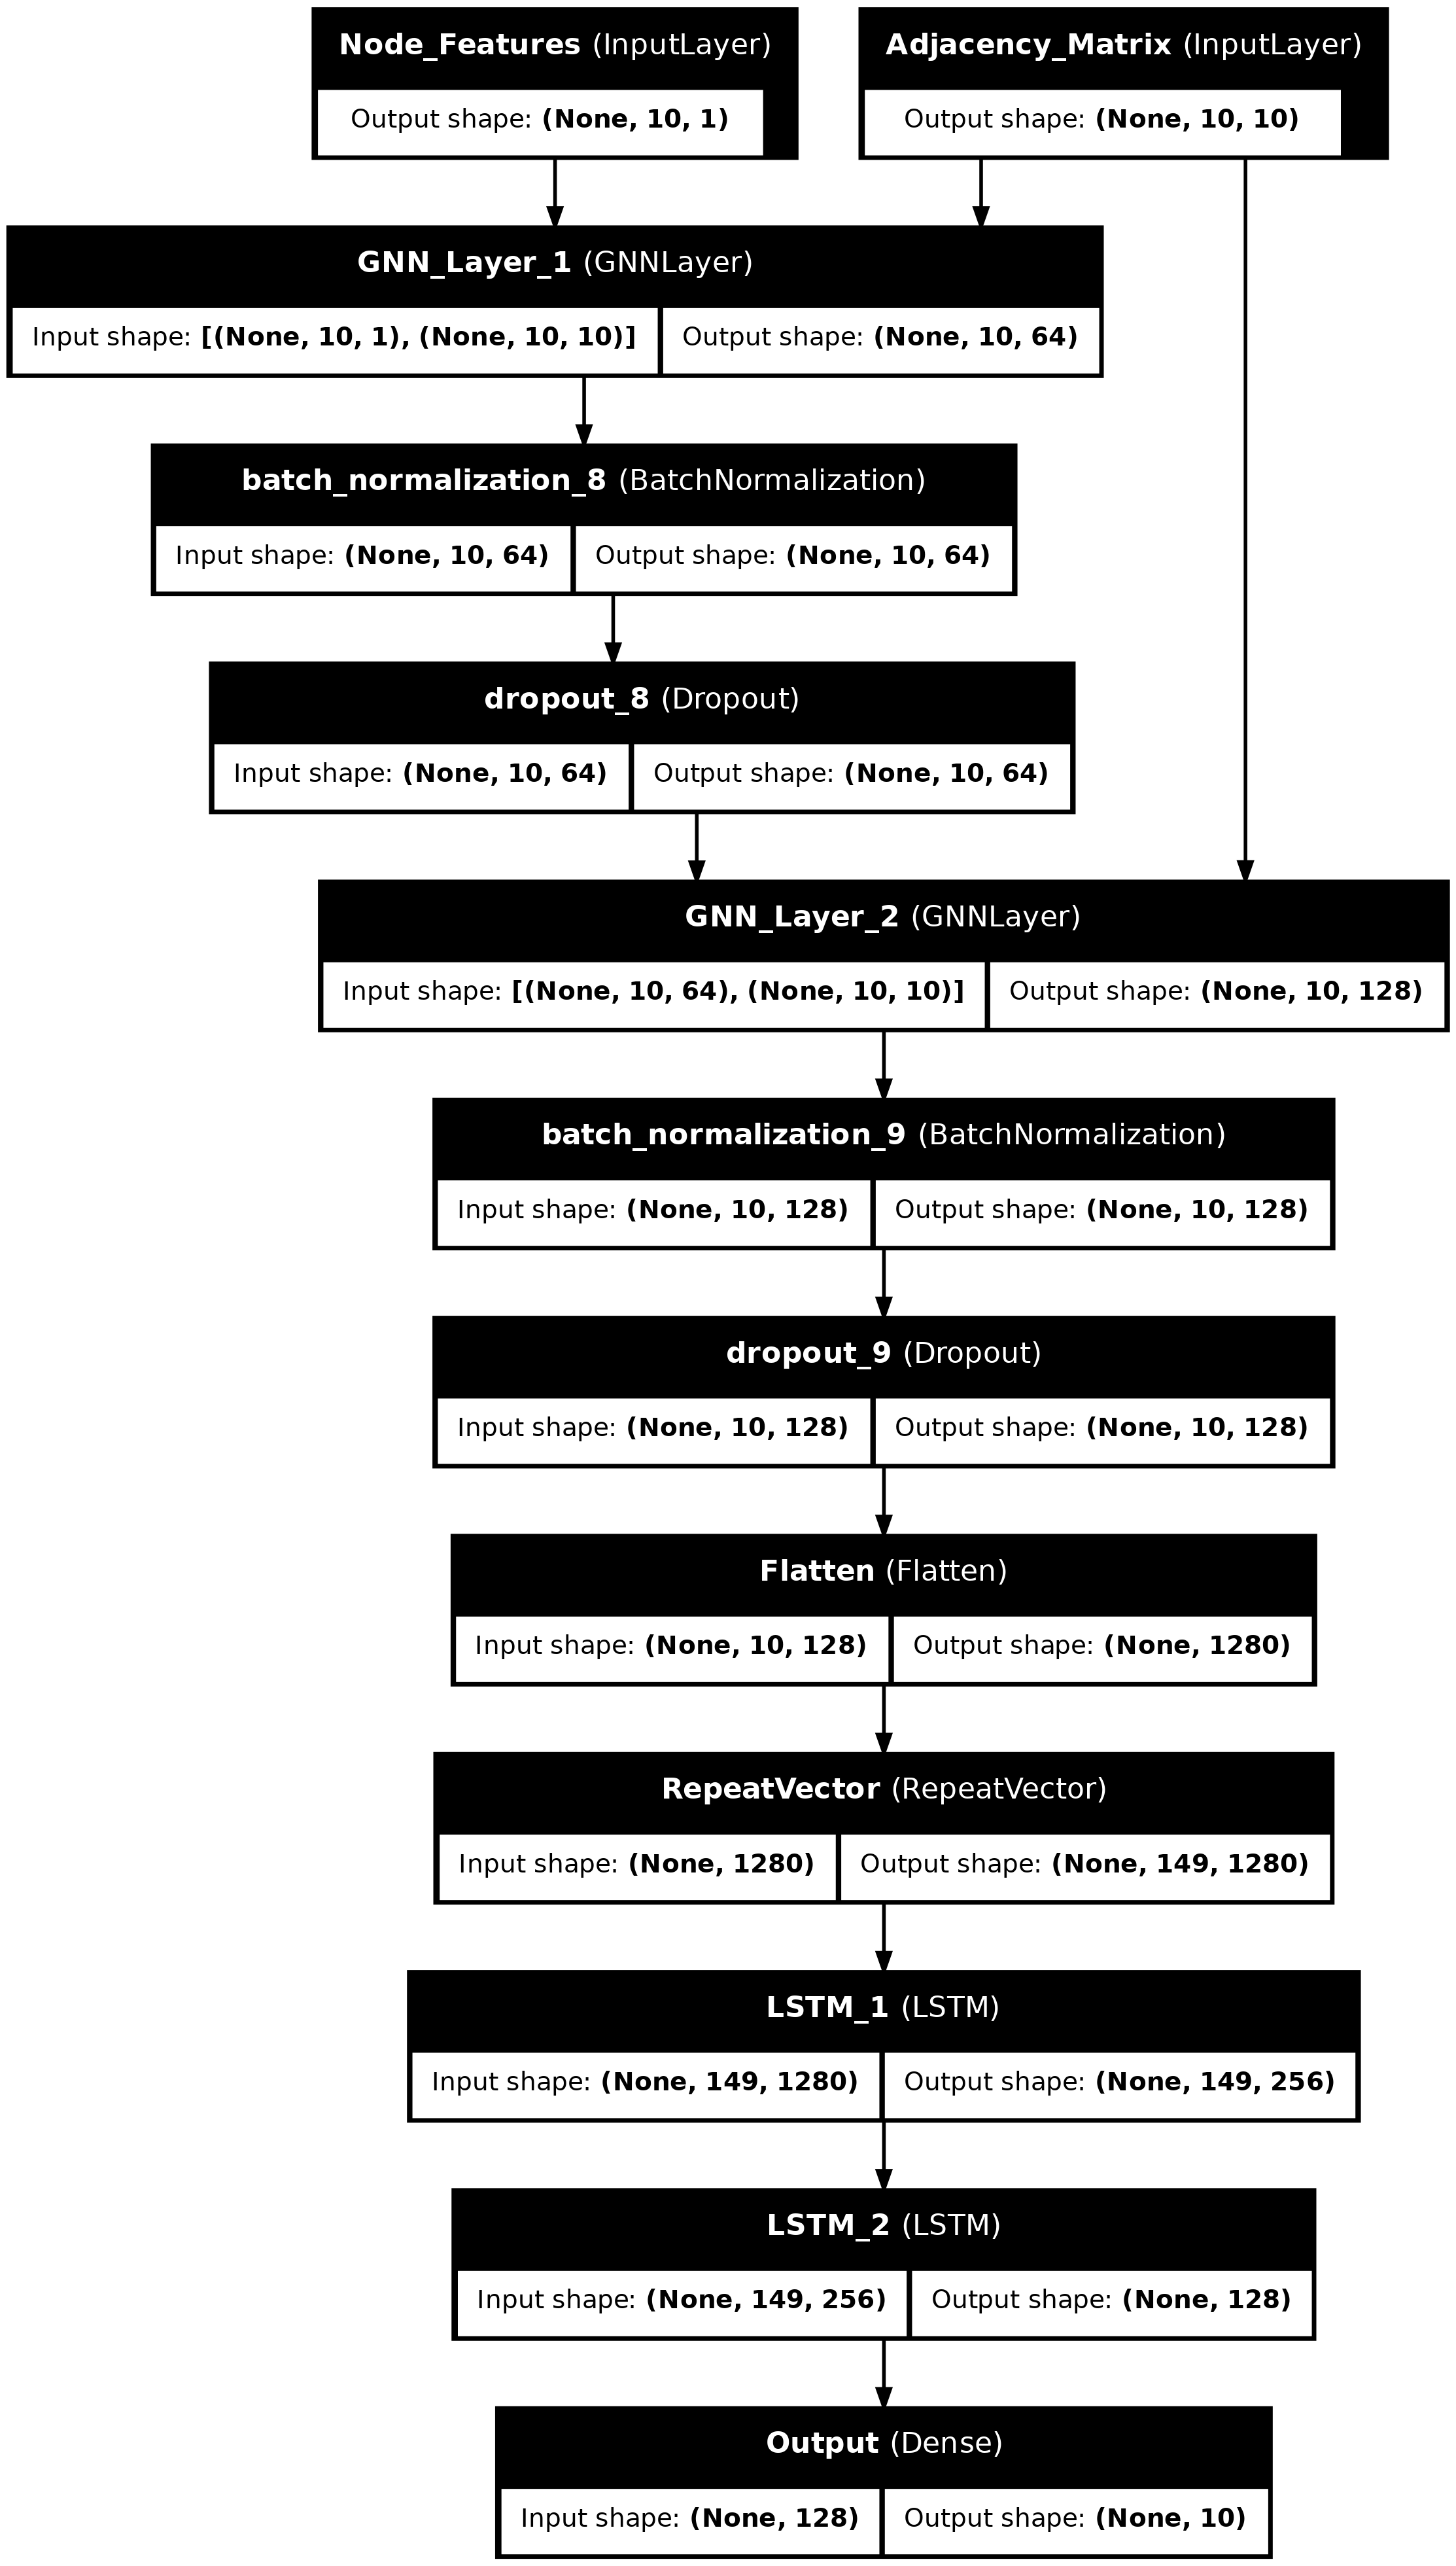

In [58]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='gnn_lstm_model.png', show_shapes=True, show_layer_names=True)

### TRAIN THE MODEL

In [59]:
model.fit([X_train, route_distances_expanded_train], y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 1.3962 - val_loss: 1.3984 - learning_rate: 0.0010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.2133 - val_loss: 1.4423 - learning_rate: 0.0010
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 1.1725 - val_loss: 1.3762 - learning_rate: 0.0010
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1956 - val_loss: 1.3590 - learning_rate: 0.0010
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1496 - val_loss: 1.3532 - learning_rate: 0.0010
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1415 - val_loss: 1.3473 - learning_rate: 0.0010
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.0958 - val_loss: 1.3333 - learning_rate: 0.0010
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1387 - val_loss: 1.3467 - learning_rate: 0.0010
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 1.1304 - val_loss: 1.3412 - learning_rate: 0.0010
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 1.10

### MODEL EVALUATION

In [60]:
loss = model.evaluate([X_test, route_distances_expanded_test], y_test)
print(f'Loss in test data: {loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 1.1260
Loss in test data: 1.1260474920272827


### MAKE PREDICTIONS

In [61]:
predictions = model.predict([X_test, route_distances_expanded_test])

print(f'Shape of y_test: {y_test.shape}')
print(f'Shape of predictions: {predictions.shape}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Shape of y_test: (30, 10, 1)
Shape of predictions: (30, 10)


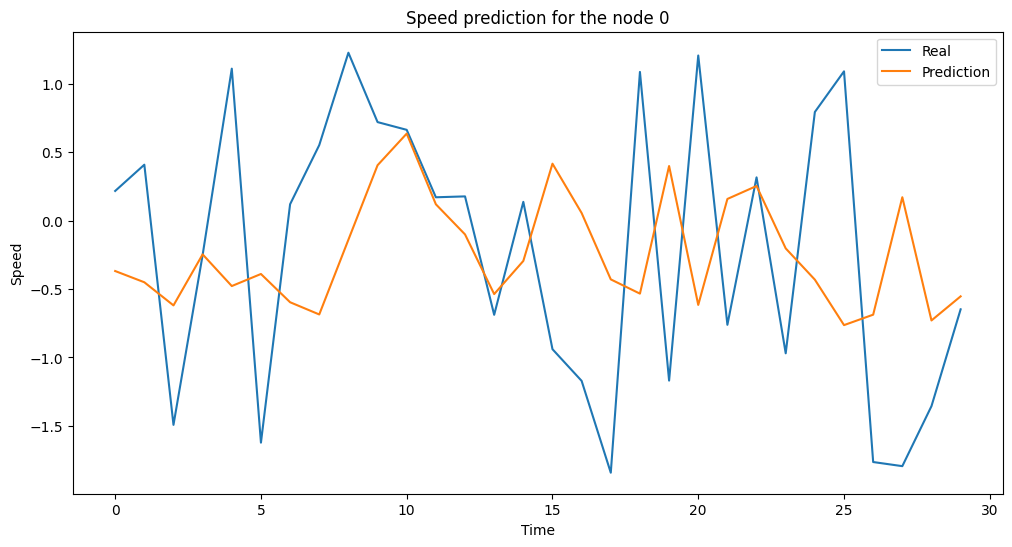

In [62]:
import matplotlib.pyplot as plt

# Select a node to display
node_index = 0

plt.figure(figsize=(12, 6))

# Get rid of the extra dimension
y_test_reshaped = y_test.squeeze(axis=-1)

plt.plot(y_test_reshaped[:, node_index], label='Real')
plt.plot(predictions[:, node_index], label='Prediction')

plt.title(f'Speed prediction for the node {node_index}')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend()
plt.show()

-------------